In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot
import sklearn.linear_model
import matplotlib.pyplot as plt
import pyreadstat
import datetime
import FG_Methods_1
import tabulate
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")


qa2a_labels = ["Crime", "Economic situation", "Rising prices/ inflation/ cost of living", "Taxation", "Unemployment", "Terrorism", "NULL", "Housing", "Government debt", "Immigration", "Health", "The education system", "Pensions", "The environment and climate change", "Energy supply", ]







In [2]:
# Initialise Values

df_path = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\data\\ZA7780_v1-0-0.dta"
df = pd.read_stata(df_path, convert_categoricals=False)
df.info()

unique_country_codes = set(df["isocntry"].values)
unique_country_codes = sorted(unique_country_codes)
print(unique_country_codes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38718 entries, 0 to 38717
Columns: 479 entries, studyno1 to w87
dtypes: float64(284), int16(5), int32(3), int8(184), object(3)
memory usage: 92.7+ MB
['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CY-TCC', 'CZ', 'DE-E', 'DE-W', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RS-KM', 'SE', 'SI', 'SK', 'TR']


In [3]:
#Output Dataframe as csv

"""project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"

df_column_headers = ""
for i in df.columns:
    if i == df.columns[0]:
        df_column_headers = i
    else:
        df_column_headers = df_column_headers + ", " + i

np.savetxt(project_folder + 'social_research_dataframe.csv',  np.asarray(df), header=df_column_headers, delimiter=',', fmt='%s')"""


'project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"\n\ndf_column_headers = ""\nfor i in df.columns:\n    if i == df.columns[0]:\n        df_column_headers = i\n    else:\n        df_column_headers = df_column_headers + ", " + i\n\nnp.savetxt(project_folder + \'social_research_dataframe.csv\',  np.asarray(df), header=df_column_headers, delimiter=\',\', fmt=\'%s\')'

In [4]:
def return_stats_on_group(df, column_names, conditions, remap_dict):
    df_filtered = df
    collected_values, collected_means = [], []
    
    for col, condition in conditions.items():
        df_filtered = df_filtered[df_filtered[col]==condition]
    for target_value in column_names:
        
        if not remap_dict == None:
            df_remapped = remap_vector(df_filtered[target_value], remap_dict)
        else:
            df_remapped = df_filtered[target_value]
            
        collected_means  = np.append(collected_means, df_remapped.mean())
        collected_values = np.append(collected_values, df_remapped)
    
    output_mean, output_std = collected_means.mean(), np.nanstd(np.array(collected_values).std())
    output_mean, output_std = float("{:.2f}".format(output_mean)), float("{:.2f}".format(output_std))
    
    return output_mean, output_std

def run_study(unit_group_request_list, unit_group_column, unit_group_name, data_request_list):
    df_results = pd.DataFrame()
    
    for unit_request in unit_group_request_list:
        unit_request_2 = {unit_group_column: v for v in unit_request["unit_group"]}
        
        for data_request in data_request_list:
            remap_dict = data_request["remap_dict"]
            output_mean, output_std = return_stats_on_group(df, data_request['data_group'], unit_request_2, remap_dict)
            
            #enter data to series - FG_note: this likely still clunkly, I'm not sure why I'm using all these dictionaries
            result_dict = {(data_request["data_group_name"], "mean"): output_mean, (data_request["data_group_name"], "std"): output_std}
            result_series = pd.Series(result_dict, name=unit_request["unit_name"])
            df_results = df_results.append(result_series)
    
    df_results[unit_group_name] = df_results.index
    df_results = df_results.groupby(unit_group_name).mean()
    return df_results


def remap_vector(stats_vector, remap_dict):
    unwrap = False
    original_values = []
    new_values = []
    if not isinstance(stats_vector, list):
        original_values = stats_vector.values.tolist()
        unwrap = True
    else:
        original_values = stats_vector
        
    for i in original_values:
        new_values = new_values + [remap_dict[original_values[i]]] 
        
    if unwrap == True:
        output = np.array(new_values)
    else:
        output = new_values
    
    return output

    
    
    

In [5]:
print(datetime.datetime.now())
remap_1 = {1:4, 2:3, 3:2, 4:1, 5:None}
test_output = remap_vector(df["qa1a_2"], remap_1)
print(str(df["qa1a_2"].size))
print(datetime.datetime.now())

type(test_output)


2022-05-03 17:50:53.437904
38718
2022-05-03 17:50:56.030991


numpy.ndarray

In [6]:
# REmapping for Qa1a, below are the original values
# VeryGood-1, RatherG-2, RBad-3, VB-4, I believe 5 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_1 = {1:4, 2:3, 3:2, 4:1, 5:None}

# REmapping for Qa2a
# Better-1, Worse-2, Same-3, I believe 4 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
remap_2 = {1:4, 2:1, 3:2.5, 4:None}

unit_group_request_list = [{"unit_group" : ["GB"], "unit_name": "GB"}, 
                           {"unit_group" : ["IT"], "unit_name": "Italy"}]
unit_group_column = "isocntry"
unit_group_name = "country"
data_request_list = [{"data_group": ["qa1a_1", "qa1a_2", "qa1a_3", "qa1a_4", "qa1a_5", "qa1a_6", "qa1a_7"], "data_group_name": "qa1a", "remap_dict": remap_1},
                     {"data_group": ["qa2a_1", "qa2a_2", "qa2a_3", "qa2a_4", "qa2a_5", "qa2a_6", "qa2a_7"], "data_group_name": "qa2a", "remap_dict": remap_2}]

test_list = ["a","b"]
test_dict = {"a":1, "b":2}

print(datetime.datetime.now())
#return_stats_on_group(df, ["qa1a_2"], {"isocntry":"LT"})
df_results = run_study(unit_group_request_list, unit_group_column, unit_group_name, data_request_list)
print(df_results)
print(datetime.datetime.now())

2022-05-03 17:50:56.111340
         qa1a       qa2a     
         mean  std  mean  std
country                      
GB       2.29  0.0  3.35  0.0
Italy    2.53  0.0  3.05  0.0
2022-05-03 17:50:57.771534


0.0011013507431178252


'"Links on heatmapping and seaborn pairplot to impliment in these methods:\nhttps://seaborn.pydata.org/generated/seaborn.heatmap.html\nhttps://seaborn.pydata.org/generated/seaborn.pairplot.html\n'

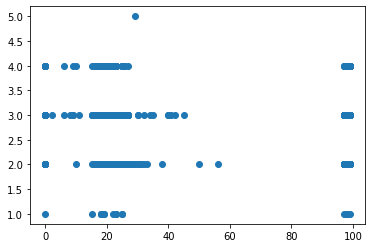

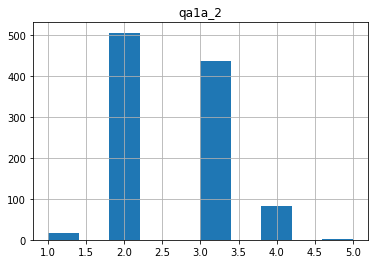

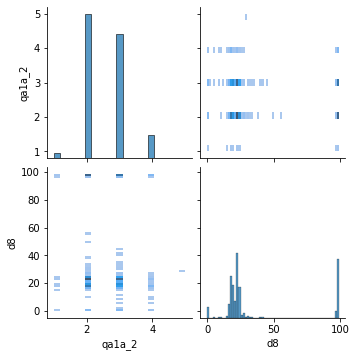

In [7]:
df_1 = df[["isocntry","qa1a_2","d8"]]
df_2 = df_1[df_1['isocntry']=="LT"]
corr_education_econ = df_2["qa1a_2"].corr(df_2["d8"])
print(corr_education_econ)


plt.scatter(df_2["d8"], df_2["qa1a_2"])
df_2.hist("qa1a_2")
sns.pairplot(df_2[['qa1a_2', "d8"]], palette="vlag", kind="hist")

""""Links on heatmapping and seaborn pairplot to impliment in these methods:
https://seaborn.pydata.org/generated/seaborn.heatmap.html
https://seaborn.pydata.org/generated/seaborn.pairplot.html
"""


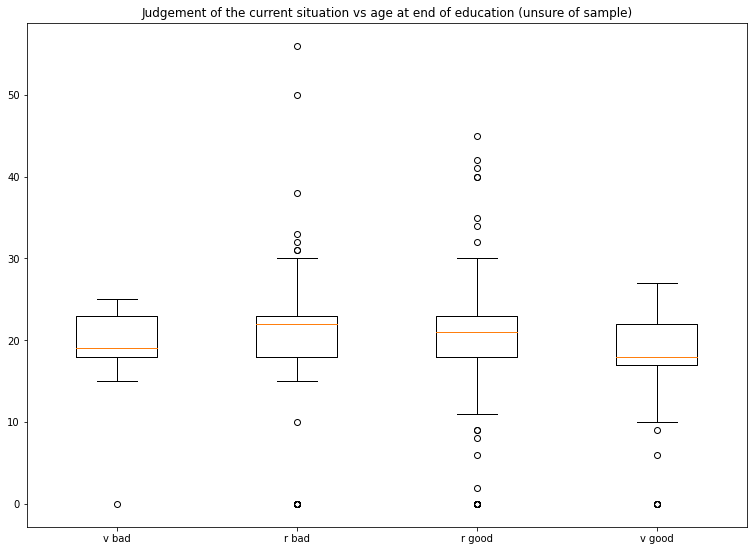

Not sure on the conclusions here, most people are in the middle. The fewer people at the extreme may explain the apparent reduction in spread shown the quartiles plot above?

Maybe age according is a better demographic to look at?


In [8]:
# VeryGood-1, RatherG-2, RBad-3, VB-4, I believe 5 is the NA value, as it has a pick rate of c. 1% and the survey NA value of 999 is not present
df_3 = df_2[df_2['d8']<80][['qa1a_2', "d8"]]
#sns.pairplot(df_3, palette="vlag", kind="hist")
df_3_very_good      = df_3[df_3['qa1a_2']==1]['d8']
df_3_rather_good    = df_3[df_3['qa1a_2']==2]['d8']
df_3_rather_bad     = df_3[df_3['qa1a_2']==3]['d8']
df_3_very_bad       = df_3[df_3['qa1a_2']==4]['d8']

data = [df_3_very_good, df_3_rather_good, df_3_rather_bad , df_3_very_bad]


fig = plt.figure(figsize = (10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['v bad', 'r bad',
                    'r good', 'v good'])
plt.title("Judgement of the current situation vs age at end of education (unsure of sample)")

# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()
print("Not sure on the conclusions here, most people are in the middle. The fewer people at the extreme may explain the apparent reduction in spread shown the quartiles plot above?")
print()
print("Maybe age according is a better demographic to look at?")

In [9]:
def digest_multiple_choice_questions(database, column_ranges):
    
    
    print("Hello")
    
    
    
test = {(1,2):0.6}

In [14]:
def transfer_columns(new_df, original_df, target_string, target_string_at_start=True, data_columns_exact_match=False):
    #this method scans every column header of original_df and if target_string is contained within a header, at column is added to new df.
    #this allows me to iterativelly add groups of columns from the original datarame to the reduced datafrom for the analysis
    #target string must be entered as a string
    columns_original = original_df.columns
    columns_new = new_df.columns
    if type(target_string) is str:
        target_string = [target_string]
    
    for string_ in target_string:
        for col in columns_original:
            if col.find(string_) >= 0 and not col in new_df and target_string_at_start==False: #FG_Note: test this additional boolean
                new_df = pd.concat([new_df, original_df[col]], axis=1)
            if col.find(string_) == 0 and not col in new_df and target_string_at_start==True:
                new_df = pd.concat([new_df, original_df[col]], axis=1)
        
    return new_df

def run_link_study_on_pre_filtered_db(df,start_column, end_column):
    test_df = pd.DataFrame()
    weights = pd.DataFrame()
    singular_values_weighted = {}
    singular_values_weighted_doubled_if_single = {}
    test_df["isocntry"] = df["isocntry"]
    #test_df["d8"] = df["d8"]
    #test_df["w1"] = df["w1"]
    test_df = transfer_columns(test_df, df, ["qa3a"], target_string_at_start=True, data_columns_exact_match=False)
    #test_df = test_df[test_df["isocntry"]=="LT"]
    results_dict = {}
    study_area = test_df.loc[:,start_column:end_column]#"qa3a_1":"qa3a_18"]
    weights["w1"] = df["w1"]
    col_qty = len(study_area.columns)
    col_names = study_area.columns
    row_names = study_area.index
    for row in range(0, len(study_area)):
        row_result = []
        #while len(row_result) < 2:
        for col in range(0,len(col_names)):
            if study_area.loc[row_names[row], col_names[col]] == 1:
                row_result = row_result + [int(col_names[col][col_names[col].find("_")+1:])]
            if len(row_result) == 2:
                break
        #add to "link dictionary" stats
        key = tuple(row_result)
        weight = weights.loc[row_names[row], :][0]
        #if len(weight) > 1:
        #    errmsg = 'Please check method can take more then one weight'
        #    raise ValueError(errmsg)
        if key in results_dict.keys():
            results_dict[key] += weight
        else:
            results_dict[key] = weight
        
        #add to singular values stats
        if len(row_result) == 1:
            adjusted_weight = 2 * weight
        else:
            adjusted_weight = weight    
        
        for i in row_result:
            if key in singular_values_weighted.keys():
                singular_values_weighted[i]                     += weight
                singular_values_weighted_doubled_if_single[i]   += adjusted_weight
            else:
                singular_values_weighted[i]                     = weight
                singular_values_weighted_doubled_if_single[i]   = adjusted_weight
        
    return results_dict, singular_values_weighted, singular_values_weighted_doubled_if_single


results_dict, singular_values_weighted, singular_values_weighted_doubled_if_single = run_link_study_on_pre_filtered_db(df[df["isocntry"]=="GB"],"qa3a_1","qa3a_18")
    



In [12]:
print(len(df.loc[0,:]))
df.info()

479
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38718 entries, 0 to 38717
Columns: 479 entries, studyno1 to w87
dtypes: float64(284), int16(5), int32(3), int8(184), object(3)
memory usage: 93.7+ MB


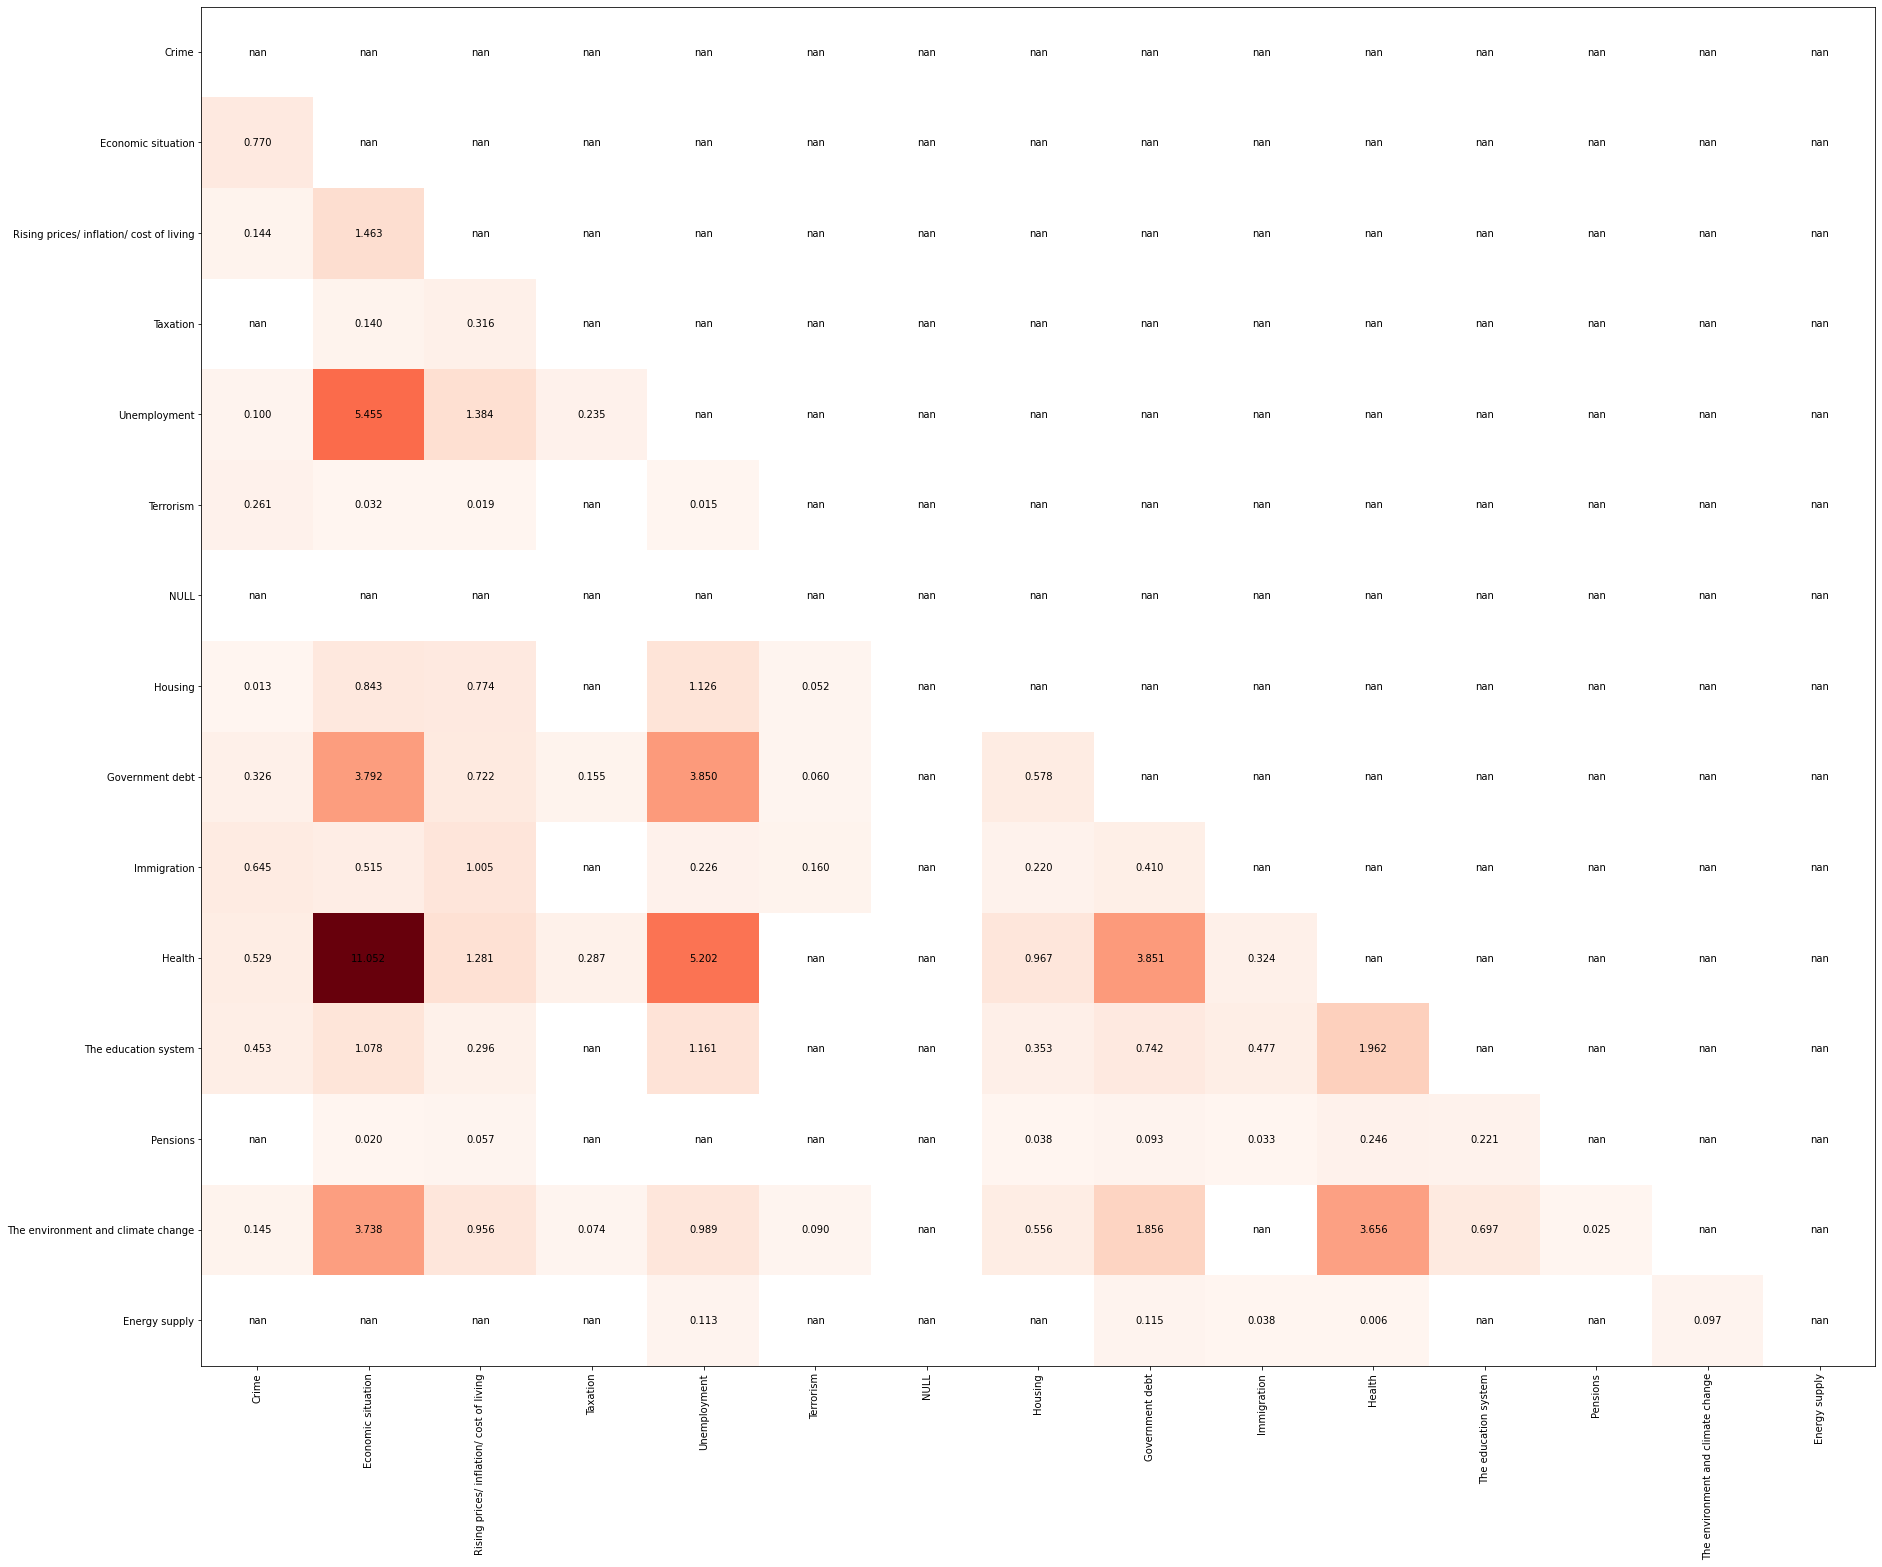

In [15]:
import numpy as np
import matplotlib.pyplot as plt

weight_relative_to_pop = True
total_pop_weight = sum(singular_values_weighted.values())

# generate some example data
dim = max(list(singular_values_weighted.keys())) - min(list(singular_values_weighted.keys())) + 1
matrix = np.empty((dim, dim,))
matrix[:] = np.nan

for keys in results_dict:
    if len(keys) == 2:
        value = results_dict[keys]
        if weight_relative_to_pop == True:
            value = value / total_pop_weight
        matrix[keys[0]-1, keys[1]-1] = value #values
        

for y in range(0, dim):
    for x in range(0, dim):
        if matrix[x, y] == np.nan:
            matrix[x, y] = 0

# plot the matrix as an image with an appropriate colormap
plt.imshow(matrix.T, aspect='auto', cmap="Reds")

# add the values
for (i, j), value in np.ndenumerate(matrix):
    plt.text(i, j, "%.3f"%value, va='center', ha='center')

tickvalues = range(0,dim)
plt.xticks(ticks = tickvalues ,labels = qa2a_labels, rotation = 'vertical')
plt.yticks(ticks = tickvalues ,labels = qa2a_labels, rotation = 'horizontal')

plt.rcParams["figure.figsize"] = (30,25)



#plt.axis('off')
plt.show()


